Learn iterator for multiphase elastic problems using PAC-FEANet

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader
from torch.nn.modules.utils import _pair
import os
import numpy as np
import matplotlib.pyplot as plt
import math
import random
import time
from functools import reduce

from utils import plot
import feanet.pac as pac
from feanet.model import PACFEANet
from feanet.jacobi import JacobiBlock
from data.dataset import ThermalDataSet

Test PAC-FEANet for thermal problems

In [8]:
device_predict = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') #torch.device('cpu') #
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [9]:
train = True # True or False
model_name = 'thermal_type2_1phase_33x33_m'
training_set = ThermalDataSet('data/thermal/thermal_type2_1phase_33x33.h5', device)
model_dir = 'model/learn_iterator/thermal_type2'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

nb_layers = 3
bs = 5
train_dataloader = DataLoader(training_set, batch_size=bs, shuffle=True)
dirich_idx_train, dirich_value_train, neumann_idx_train, neumann_value_train, material_train, f_train, u_train = next(iter(train_dataloader))
k = 0 # the index of training data to be shown

In [10]:
n_test = 2**5
test_set = ThermalDataSet('data/thermal/thermal_type2_1phase_33x33.h5', device)

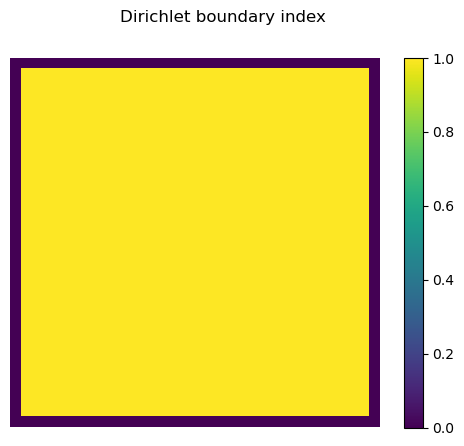

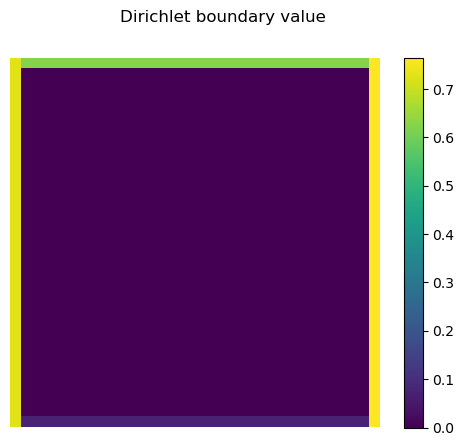

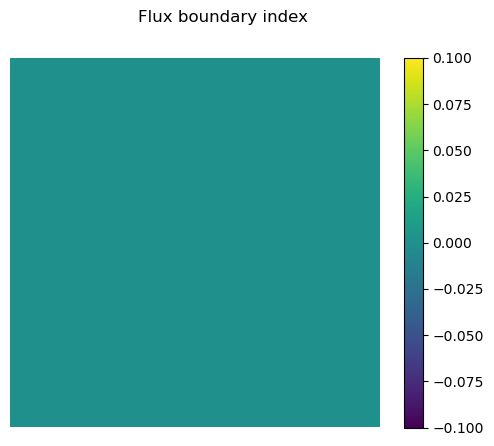

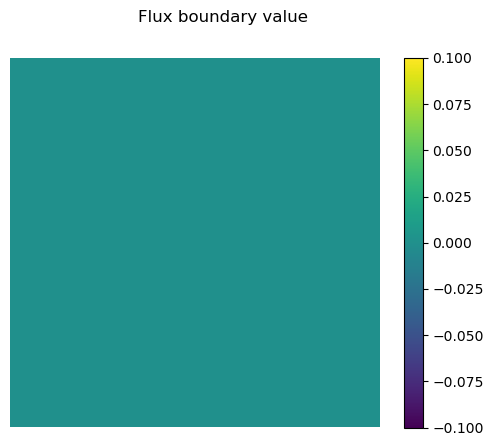

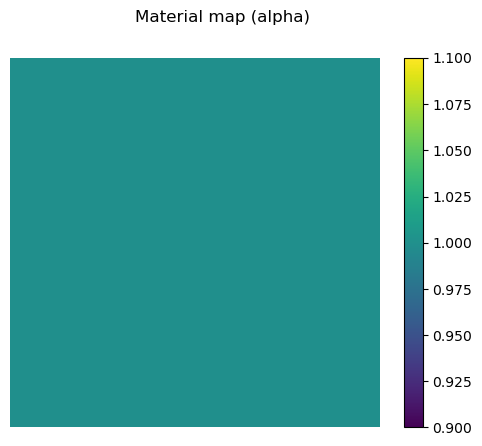

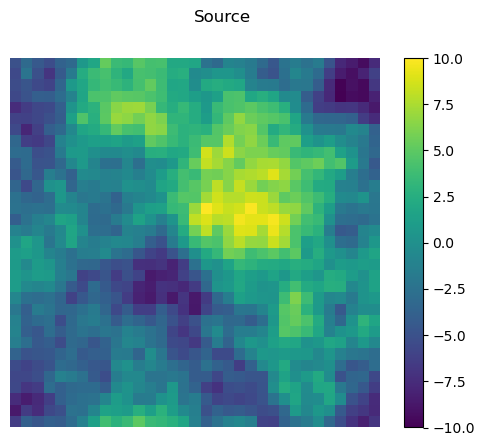

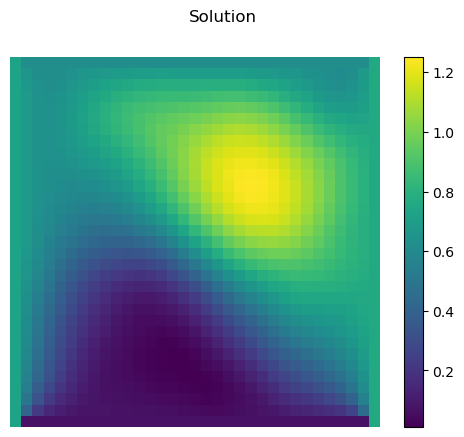

''

In [11]:
plot.plot_thermalfield(dirich_idx_train[k], ftitle='Dirichlet boundary index')

plot.plot_thermalfield(dirich_value_train[k], ftitle='Dirichlet boundary value')
plot.plot_thermalfield(neumann_idx_train[k], ftitle='Flux boundary index')
plot.plot_thermalfield(neumann_value_train[k], ftitle='Flux boundary value')
plot.plot_thermalfield(material_train[k], ftitle='Material map (alpha)')
plot.plot_thermalfield(f_train[k], ftitle='Source')
plot.plot_thermalfield(u_train[k], ftitle='Solution')
''''''

In [12]:
class SingleGrid():
    '''
    Perform weighted Jacobi iteration relaxation for a single grid.
    '''
    def __init__(self, size, n_elem, mode, dev):
        self.size = size # actual size of the plate
        self.mode = mode
        self.device = dev
        self.n_elem = n_elem
        self.h = size/n_elem
        self.v = torch.zeros((1, 1, n_elem+1, n_elem+1), requires_grad=False).double()
        self.f = torch.zeros((1, 1, n_elem+1, n_elem+1), requires_grad=False).double()
        self.net = self.InstantiateNetwork()
        self.jac = JacobiBlock(self.net, self.h, self.device, self.mode)

    def IsCoarsest(self):
        return self.n_elem == 2
        
    def InstantiateNetwork(self):
        model = PACFEANet(self.device, self.mode).double()
        model.requires_grad_(False)
        return model.to(self.device)

In [13]:
domain_size = 2
n_elem = 2**5
ku, kf = 1, 1
h = domain_size/n_elem
grid = SingleGrid(domain_size, n_elem=n_elem, mode='thermal', dev=device_predict)

In [14]:
solution_test, f_test, d_test, d_idx_test, t_test, t_idx_test, m_test = (torch.unsqueeze(u_train[k], 0).to(device_predict), 
                                                                         torch.unsqueeze(f_train[k], 0).to(device_predict), 
                                                                         torch.unsqueeze(dirich_value_train[k], 0).to(device_predict), 
                                                                         torch.unsqueeze(dirich_idx_train[k], 0).to(device_predict), 
                                                                         torch.unsqueeze(neumann_value_train[k], 0).to(device_predict), 
                                                                         torch.unsqueeze(neumann_idx_train[k], 0).to(device_predict), 
                                                                         torch.unsqueeze(material_train[k], 0).to(device_predict))


0 6.002187051756626
1 3.414431520865241
2 2.5069501568715493
3 2.026679906541995
4 1.7238725343585974
5 1.513089396564476
6 1.356679310536561
7 1.2353149587031982
8 1.1379909018853365
9 1.0579472087368063
10 0.9907838558625413
11 0.9335025922442629
12 0.8839831819055112
13 0.840679779551527
14 0.8024361904711999
15 0.7683687997206201
16 0.7377897627362322
17 0.7101550756613759
18 0.6850285340125943
19 0.6620561346617035
20 0.6409475197922759
21 0.6214622788325976
22 0.6033996710617315
23 0.5865908017540715
24 0.5708925878533662
25 0.5561830488329573
26 0.5423575925184104
27 0.5293260573747413
28 0.517010336543117
29 0.5053424539511921
30 0.49426299508285104
31 0.4837198184118258
32 0.47366699071562324
33 0.4640639022836877
34 0.4548745276521736
35 0.4460668047995824
36 0.43761211133250405
37 0.4294848205147799
38 0.4216619233617398
39 0.41412270566419096
40 0.406848470894608
41 0.3998223016073067
42 0.3930288532706738
43 0.38645417553518624
44 0.38008555680136014
45 0.37391138864969703

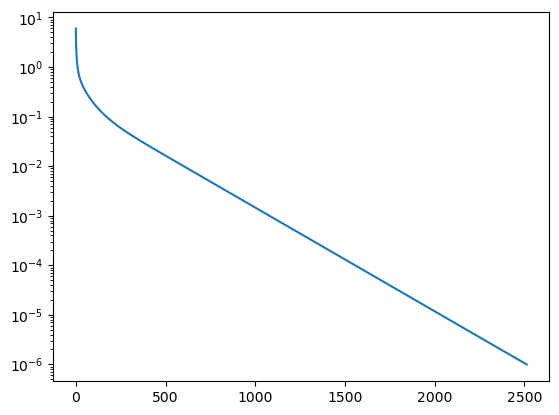

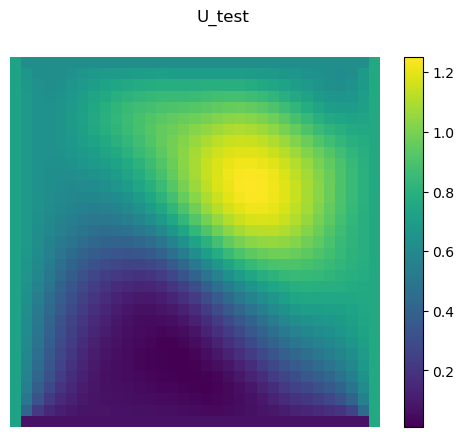

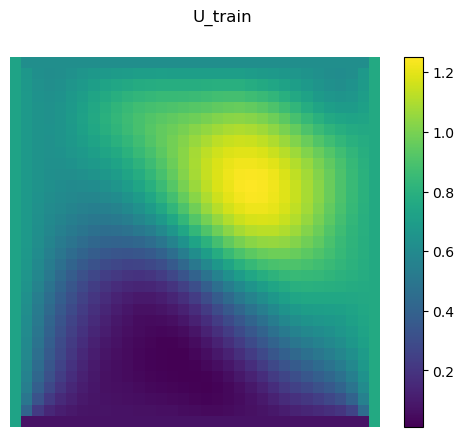

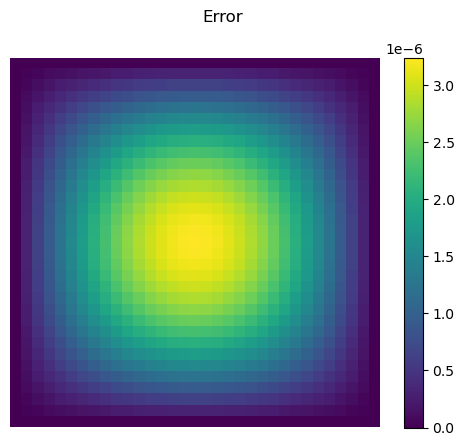

In [15]:
EPS = 1e-6
n_jac = 0
u_test = torch.ones(size=(1, ku, n_elem+1, n_elem+1), requires_grad=False, dtype=torch.double).to(device_predict)
u_test = grid.jac.reset_boundary(u_test, d_test, d_idx_test)
residual = d_idx_test*grid.net(None, None, h, u_test, f_test, t_test, t_idx_test, m_test)
res = torch.norm(residual).item() 
res_arr = [res]

print(n_jac, res)
while (abs(res) > EPS):
    u_test = grid.jac.jacobi_convolution(u_test, m_test, d_test, d_idx_test, None, None, h, f_test, t_test, t_idx_test)
    residual = d_idx_test*grid.net(None, None, h, u_test, f_test, t_test, t_idx_test, m_test)
    res = torch.norm(residual).item() 
    res_arr.append(res)
    n_jac += 1
    print(n_jac, res)

print("Solution converges after", n_jac, "Jacobi iterations ")
plt.plot(res_arr)
plt.yscale('log')
plt.show()

plot.plot_thermalfield(u_test[0], "U_test")
plot.plot_thermalfield(solution_test[0], "U_train")
plot.plot_thermalfield(u_test[0]-solution_test[0], 'Error')

In [16]:
class PsiNet(nn.Module):
    def __init__(self, nb_layers=3, mode='thermal'):
        super(PsiNet, self).__init__()

        self.mode = mode
        self.kernel = 3
        self.km, self.ku, self.kf = 1, 1, 1 # thermal problem
        if(self.mode == 'elastic'):
            self.km, self.ku, self.kf = 2, 2, 2
            
        self.attention_map = nn.Sequential(
            nn.Conv2d(self.km, self.km, kernel_size=2, padding=1),
            nn.Conv2d(self.km, self.kernel*self.kernel, kernel_size=5, padding=2),
            nn.BatchNorm2d(self.kernel*self.kernel)
            )

        self.nonlinear = nn.Tanh()
        self.smoother = nn.ModuleList([nn.Conv2d(self.ku, self.ku, 3, padding=1, bias=False)
                                         for _ in range(nb_layers)])
        self.smoother.insert(0, nn.Conv2d(self.kernel*self.kernel*self.ku, self.ku, kernel_size=1))

    def forward(self, m, x, dirich_idx):
        '''
        m: material field
        x: error between Jacobi solution and initial guess '''
        
        bs0, ku0, h0, w0 = x.size()
        new_x = F.unfold(x, kernel_size = 3, padding = 1).view(bs0, -1, h0, w0) # shape (bs, 9ku, h, w)
        attention = self.nonlinear(self.attention_map(m)) # shape (bs, 9, h, w)
        attention = attention.repeat(1, self.ku, 1, 1) # shape (bs, 9ku, h, w)
        attention_x = new_x * attention # shape (bs, 9ku, h, w)
        return reduce(lambda acc, el: el(acc) * dirich_idx, self.smoother, attention_x) # shape (bs, ku, h, w)

In [17]:
class PsiIterator(nn.Module):
    def __init__(self, 
                 dev,
                 size=2, 
                 psi_net=None,
                 grid=None,
                 n=2**5,
                 nb_layers=3,
                 batch_size=1,
                 max_epochs=1000,
                 mode='thermal',
                 model_dir=model_dir):
        super(PsiIterator, self).__init__()
        self.size = size
        self.device = dev
        self.n = n
        self.h = size/n
        self.mode = mode
        self.batch_size = batch_size
        self.max_epochs = max_epochs
        self.loss = nn.MSELoss()
        
        if(grid is None):
            self.grid = SingleGrid(size, n, mode=mode, dev=self.device)
        else:
            self.grid = grid

        if(psi_net is None):
            self.psi_net = PsiNet(nb_layers=nb_layers, mode=self.mode).to(self.device).double()
        else:
            self.psi_net = psi_net.to(self.device).double()

        self.optimizer = torch.optim.Adadelta(self.psi_net.parameters())
        self.model_dir=model_dir

    def PsiRelax(self, v, m, d, d_idx, term_KU=None, term_F=None, h=None, f=None, t=None, t_idx=None, num_sweeps_down=1):
        '''
        Perform a fixed number of Psi iteration
        '''
        u = v.clone()
        for _ in range(num_sweeps_down):
            jac_it = self.grid.jac.jacobi_convolution(u, m, d, d_idx, term_KU, term_F, h, f, t, t_idx)
            u = jac_it + self.psi_net(m, jac_it-u, d_idx) 
        return u

    def RandomSampling(self, x):
        u = torch.randn_like(x).double().to(self.device)
        return u

    def TrainSingleEpoch(self, train_dataloader):
        running_loss = 0.
        for i, data in enumerate(train_dataloader):
            dirich_idx_train, dirich_value_train, traction_idx_train, traction_value_train, material_train, f_train, u_train = data
        
            #print(u_train.shape)
            self.optimizer.zero_grad() # zero the gradients for every batch
            k = 1 #random.randint(1,20)

            uu = self.RandomSampling(f_train)
            u_out = self.PsiRelax(uu, material_train, dirich_value_train, dirich_idx_train, None, None, self.h, f_train, traction_value_train, traction_idx_train, k)
            loss_i = self.loss(u_out, u_train)
            loss_i.backward()
            self.optimizer.step()
        
            running_loss += loss_i.item()
    
        last_loss = running_loss/(i+1)
        return last_loss
    
    def Train(self, training_set):
        train_dataloader = DataLoader(training_set, batch_size=self.batch_size, shuffle=True)
        loss_train = torch.zeros((self.max_epochs, 1))
        avg_loss = self.TrainSingleEpoch(train_dataloader)
        loss_train[0] = avg_loss
        print('Step-0 loss:', avg_loss)

        for epoch in range(1, self.max_epochs):
            avg_loss = self.TrainSingleEpoch(train_dataloader)
            if(epoch % 50 == 0):
                print('Step-'+str(epoch)+' loss:', avg_loss)

            # save the model's state
            mpath = os.path.join(self.model_dir,model_name+'.pth')
            torch.save(self.psi_net.state_dict(), mpath)
            loss_train[epoch] = avg_loss
        return loss_train

Step-0 loss: 0.4601164275442233
Step-50 loss: 0.08910078844443681
Step-100 loss: 0.08874359451045263
Step-150 loss: 0.0889671198037324
Step-200 loss: 0.08802957382250677
Step-250 loss: 0.08904037516634353
Step-300 loss: 0.0850034229162873
Step-350 loss: 0.08491399367733947
Step-400 loss: 0.08715597438896847
Step-450 loss: 0.08426327328456454
Step-500 loss: 0.08616076322471375
Step-550 loss: 0.0859461689731775
Step-600 loss: 0.08703542917281651
Step-650 loss: 0.08695079717398947
Step-700 loss: 0.08497278396808651
Step-750 loss: 0.08539076768147918
Step-800 loss: 0.08387517618267346
Step-850 loss: 0.08678931759909772
Step-900 loss: 0.08535648290130445
Step-950 loss: 0.08580127579466801
Average loss:  tensor(0.0853) , STD:  tensor(0.0016)


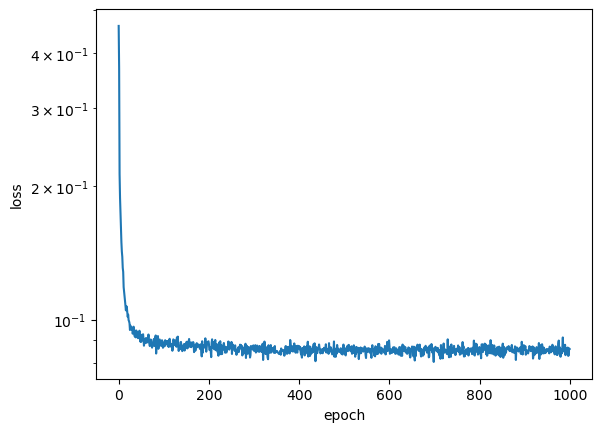

In [18]:
max_epochs = 1000
my_iterator = PsiIterator(device, batch_size=bs, mode='thermal', nb_layers=nb_layers, max_epochs=max_epochs)

loss_train = torch.zeros((max_epochs, 1))
if(train):
    loss_train = my_iterator.Train(training_set)

    plt.plot(loss_train)
    plt.ylabel('loss')
    plt.yscale('log')
    plt.xlabel('epoch')
    print("Average loss: ", torch.mean(loss_train[-100:]), ", STD: ", torch.std(loss_train[-100:]))

    # save the list
    torch.save(loss_train, os.path.join(model_dir,model_name+'.pt'))


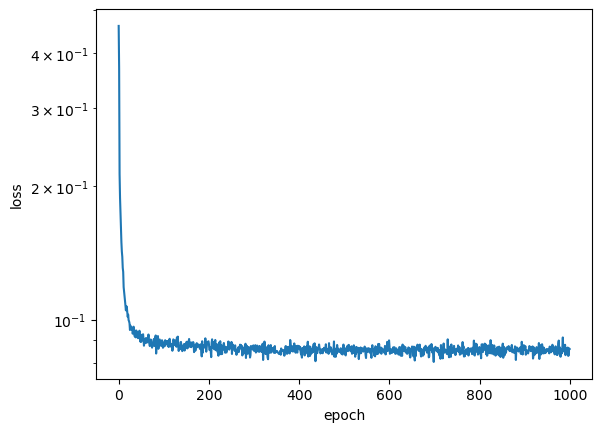

In [19]:
# import the learned model and loss train
my_net = PsiNet(nb_layers=nb_layers, mode='thermal').to(device_predict)
my_net.eval()
my_net.load_state_dict(torch.load(os.path.join(model_dir,model_name+'.pth')))
new_iterator = PsiIterator(device_predict, nb_layers=nb_layers, psi_net=my_net, grid=grid, batch_size=1)

my_loss = torch.load(os.path.join(model_dir,model_name+'.pt'))
plt.plot(my_loss)
plt.ylabel('loss')
plt.yscale('log')
plt.xlabel('epoch')
plt.savefig('results/smoother_loss.jpg', dpi=500, bbox_inches='tight')

0 6.002187051756626
1 2.9226566127774287
2 2.2669657083988293
3 2.3362323765545
4 2.453286691240311
5 2.5574356740085205
6 2.650421139715744
7 2.735568803522837
8 2.8147608395776818
9 2.8890695734812084
10 2.959135635328576
11 3.0253578916695525
12 3.0879973774997516
13 3.1472381271927667
14 3.203223501011824
15 3.2560774656556246
16 3.3059165011305702
17 3.352855743974989
18 3.3970116844447418
19 3.4385028898981767
20 3.4774496705639084
21 3.5139732432733517
22 3.5481947187755565
23 3.580234094361271
24 3.610209345377266
25 3.6382356566038703
26 3.6644248041651726
27 3.6888846821059778
28 3.7117189595654914
29 3.7330268511856852
30 3.75290298288851
31 3.771437336141777
32 3.7887152555303136
33 3.80481750640139
34 3.819820371307974
35 3.8337957757963657
36 3.8468114357159138
37 3.858931019649104
38 3.870214321274404
39 3.8807174374981095
40 3.8904929490458793
41 3.899590100912406
42 3.908054980649616
43 3.9159306929501865
44 3.923257529370561
45 3.9300731323518066
46 3.9364126529494774

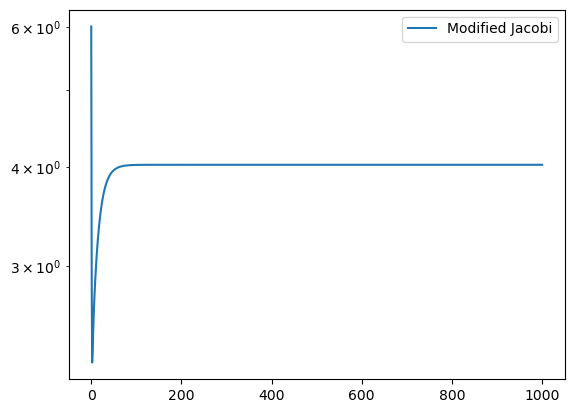

In [20]:
EPS = 1e-6
with torch.no_grad():
    n_new = 0
    u_test = torch.ones(size=(1, ku, n_elem+1, n_elem+1), requires_grad=False, dtype=torch.double).to(device_predict)
    u_test = new_iterator.grid.jac.reset_boundary(u_test, d_test, d_idx_test)
    residual = d_idx_test*new_iterator.grid.net(None, None, h, u_test, f_test, t_test, t_idx_test, m_test)
    res = torch.norm(residual).item() # fix top, apply traction force at bottom boundary
    res_arr_new = [res]
    print(n_new, res)
    while (abs(res) > EPS and n_new < 1000):
        u_test = new_iterator.PsiRelax(u_test, m_test, d_test, d_idx_test, None, None, h, f_test, t_test, t_idx_test, 1)
        residual = d_idx_test*new_iterator.grid.net(None, None, h, u_test, f_test, t_test, t_idx_test, m_test)
        res = torch.norm(residual).item()
        res_arr_new.append(res)
        n_new += 1
        print(n_new, res)

print("Solution converges after", n_new, "iterations ")
plt.plot(res_arr_new, label='Modified Jacobi')
#plt.plot(res_arr, label='Jacobi')
plt.yscale('log')
plt.legend()
plt.show()

In [21]:
# test multigrid performance

class RestrictionNet(nn.Module):
    '''Given an initial kernel, inter-grid communication'''
    def __init__(self, chs):
        super(RestrictionNet, self).__init__()
        self.chs = chs
        self.net = nn.Conv2d(in_channels=chs, out_channels=chs, kernel_size=3, stride=2, bias=False, groups=chs) # restriction
        self.edge_net = nn.Conv1d(in_channels=chs, out_channels=chs, kernel_size=3, stride=2, bias=False, groups=chs) # restrict the edge boundaries
        for i in range(self.chs):
            self.net.state_dict()['weight'][i][0] = torch.asarray([[1., 2., 1.],
                                                                   [2., 4., 2.],
                                                                   [1., 2., 1.]]) / 4.0
            self.edge_net.state_dict()['weight'][i][0] = torch.asarray([1., 2., 1.]) / 2.0
    
    def forward(self, x):
        internal = self.net(x[:, :, 1:-1, 1:-1].clone())
        x_C = F.pad(internal,(1,1,1,1),"constant",0) # coarse grid field
        x_C[:, :,  0, 1:-1] = self.edge_net(x[:, :, 0, 1:-1].clone())
        x_C[:, :, -1, 1:-1] = self.edge_net(x[:, :, -1, 1:-1].clone())
        x_C[:, :, 1:-1,  0] = self.edge_net(x[:, :, 1:-1, 0].clone())
        x_C[:, :, 1:-1, -1] = self.edge_net(x[:, :, 1:-1, -1].clone())
        x_C[:,:,0,0] = x[:,:,0,0]
        x_C[:,:,0,-1] = x[:,:,0,-1]
        x_C[:,:,-1,0] = x[:,:,-1,0]
        x_C[:,:,-1,-1] = x[:,:,-1,-1]
        return x_C


class ProlongationNet(nn.Module):
    '''Given an initial P kernel'''
    def __init__(self, chs):
        super(ProlongationNet, self).__init__()
        self.chs = chs
        self.net = nn.ConvTranspose2d(in_channels=chs,out_channels=chs, kernel_size=3, stride=2, padding=1, bias=False, groups=chs) # interpolation
        for i in range(self.chs):
            self.net.state_dict()['weight'][i][0] = torch.asarray([[1., 2., 1.],
                                                                   [2., 4., 2.],
                                                                   [1., 2., 1.]]) / 4.0
            
    def forward(self, x): 
        return self.net(x)

In [22]:
class MultiGrid(nn.Module):
    '''Define the multigrid problem for 2D, n is the finest grid size'''
    def __init__(self, n, pacnet, device, nb_layers, mode='thermal', iterator = 'jac'):
        super(MultiGrid, self).__init__()

        # Problem parameters
        self.device = device
        self.size = 2.
        self.nb_layers = nb_layers
        self.n = n # number of grid intervals for finest grid edges
        self.L = int(np.log2(n)) # multigrid iteration
        self.pacnet = pacnet
        self.iterator = iterator
        
        self.mode = mode
        self.km, self.ku, self.kf = 1, 1, 1 # thermal problem
        if(self.mode == 'elastic'):
            self.km, self.ku, self.kf = 2, 2, 2

        self.iterators = self.IteratorDict() # dictionary of iterators

        # Inter-grid communication network models
        self.conv = RestrictionNet(self.kf).double().to(device)
        self.deconv = ProlongationNet(self.ku).double().to(device)
        
        self.conv.requires_grad_(False)
        self.deconv.requires_grad_(False)

        self.mse_loss = nn.MSELoss()
    
    def IteratorDict(self):
        iterators = {}
        for i in range(self.L):
            prob_size = int(self.n/(2.**i))
            iterators[i] = PsiIterator(self.device, size=self.size, psi_net=self.pacnet, n=prob_size, nb_layers=self.nb_layers, mode=self.mode)
        return iterators
            
    def ProblemDictArray(self, u0, f, t, t_idx, d, d_idx, m):
        '''
        Array of dictionary that stores the problem hierarchy
        There are two approaches that can be used to create grid hierarchy:
        1) mat = F.conv2d(mat.reshape((1,1,n,n)), torch.ones((1,1,1,1)), stride=2)
        2) mat = F.max_pool2d(mat.reshape((1,1,n,n)), kernel_size=2, stride=2)
        '''
        kernel_u = torch.ones((self.ku,1,1,1)).double().to(self.device)
        kernel_f = torch.ones((self.kf,1,1,1)).double().to(self.device)
        prob = {}
        prob['h'] = self.size/self.n
        prob['u0'] = self.iterators[0].grid.jac.reset_boundary(u0, d, d_idx)
        prob['f'], prob['t'], prob['t_idx'] = f.clone(), t.clone(), t_idx.clone()
        prob['d'], prob['d_idx'], prob['m'] = d.clone(), d_idx.clone(), m.clone()
        self.p_arr = [prob]
        for i in range(self.L-1):
            prob = {}
            prob['h'] = self.size/self.n*(2.**(i+1))
            prob['u0'] = F.conv2d(self.p_arr[i]['u0'], kernel_u, stride=2, groups=self.ku)
            prob['f'] = F.conv2d(self.p_arr[i]['f'], kernel_f, stride=2, groups=self.kf)
            prob['t'] = F.conv2d(self.p_arr[i]['t'], kernel_f, stride=2, groups=self.kf)
            prob['t_idx'] = F.conv2d(self.p_arr[i]['t_idx'], kernel_f, stride=2, groups=self.kf)
            prob['d'] = 0.*F.conv2d(self.p_arr[i]['d'], kernel_u, stride=2, groups=self.ku) # Dirichlet boundary is homogeneous at coarse grids
            prob['d_idx'] = F.conv2d(self.p_arr[i]['d_idx'], kernel_u, stride=2, groups=self.ku)
            prob['m'] = F.max_pool2d(self.p_arr[i]['m'], kernel_size=2, stride=2)
            self.p_arr.append(prob)

    def Restrict(self, rF):
        '''
        Perform restriction operation to down sample to next (coarser) level
        '''
        rFC = self.conv(rF.clone())
        return rFC

    def Interpolate(self, eFC):
        '''
        Perform interpolation and upsample to previous (finer) level 
        '''
        eF = self.deconv(eFC.clone())
        return eF 

    def forward(self, k):
        U = self.p_arr[0]['u0'].clone()
        for i in range(k-1):
            U = self.Step(U).detach()
        self.last_v = U.clone()
        return self.Step(U)

    def Relax(self, iter, u, m, d, d_idx, term_KU=None, term_F=None, h=None, f=None, t=None, t_idx=None, n_iter=1):
        if(self.iterator == 'jac'):
            return iter.grid.jac.jacobi_convolution(u, m, d, d_idx, term_KU, term_F, h, f, t, t_idx)
        else:
            return iter.PsiRelax(u, m, d, d_idx, term_KU, term_F, h, f, t, t_idx, n_iter)

    def Step(self, v):
        '''Input v is the initial solution on the finest grid'''
        n_relax = 1 # number of relaxations        
        self.iterators[0].grid.v = self.Relax(self.iterators[0], v, self.p_arr[0]['m'], 
                                              self.p_arr[0]['d'], self.p_arr[0]['d_idx'],
                                              None, None,
                                              self.p_arr[0]['h'], self.p_arr[0]['f'], 
                                              self.p_arr[0]['t'], self.p_arr[0]['t_idx'], 
                                              n_relax)
        self.iterators[0].grid.f = self.iterators[0].grid.net.term_F

        for j in range(0, self.L-1):
            # calculate fine grid residual
            rF = self.iterators[j].grid.net(u=self.iterators[j].grid.v, material_input=self.p_arr[j]['m'],
                                            term_F=self.iterators[j].grid.f)
            self.iterators[j+1].grid.f = self.Restrict(rF)
            self.iterators[j+1].grid.v = torch.zeros_like(self.iterators[j+1].grid.f) 
            self.iterators[j+1].grid.v = self.Relax(self.iterators[j+1], self.iterators[j+1].grid.v, 
                                              self.p_arr[j+1]['m'], 
                                              self.p_arr[j+1]['d'], self.p_arr[j+1]['d_idx'],
                                              term_F=self.iterators[j+1].grid.f, 
                                              n_iter=n_relax)

        self.iterators[self.L-1].grid.v = self.Relax(self.iterators[self.L-1], self.iterators[self.L-1].grid.v, 
                                              self.p_arr[self.L-1]['m'], 
                                              self.p_arr[self.L-1]['d'], self.p_arr[self.L-1]['d_idx'],
                                              term_F=self.iterators[self.L-1].grid.f, 
                                              n_iter=n_relax)

        for j in range(self.L-2,-1,-1):
            eF_delta = self.Interpolate(self.iterators[j+1].grid.v)
            self.iterators[j].grid.v = self.iterators[j].grid.v + eF_delta
            self.iterators[j].grid.v = self.Relax(self.iterators[j], self.iterators[j].grid.v, 
                                              self.p_arr[j]['m'], 
                                              self.p_arr[j]['d'], self.p_arr[j]['d_idx'],
                                              term_F=self.iterators[j].grid.f, 
                                              n_iter=n_relax)

            # zero out the previous level solution
            self.iterators[j+1].grid.v *= 0. 

        return self.iterators[0].grid.v 

In [23]:
bs = 5
train_dataloader = DataLoader(test_set, batch_size=bs, shuffle=True)
dirich_idx_train, dirich_value_train, neumann_idx_train, neumann_value_train, material_train, f_train, u_train = next(iter(train_dataloader))
k=2
solution_test, f_test, d_test, d_idx_test, t_test, t_idx_test, m_test = (torch.unsqueeze(u_train[k], 0).to(device_predict), 
                                                                         torch.unsqueeze(f_train[k], 0).to(device_predict), 
                                                                         torch.unsqueeze(dirich_value_train[k], 0).to(device_predict), 
                                                                         torch.unsqueeze(dirich_idx_train[k], 0).to(device_predict), 
                                                                         torch.unsqueeze(neumann_value_train[k], 0).to(device_predict), 
                                                                         torch.unsqueeze(neumann_idx_train[k], 0).to(device_predict), 
                                                                         torch.unsqueeze(material_train[k], 0).to(device_predict))


In [24]:
with torch.no_grad():
    n = n_test
    h = 2./n
    n_mg_jac = 0
    my_net.eval()
    mg_jac = MultiGrid(n=n, pacnet=my_net, device=device, iterator='jac') # create a multigrid model
    u_mg_jac = torch.ones((1, 1, n+1, n+1), requires_grad=False, dtype=torch.double).to(device)
    mg_jac.ProblemDictArray(u_mg_jac,f_test,t_test,t_idx_test,d_test,d_idx_test,m_test)
    u_mg_jac = mg_jac.p_arr[0]['u0']
    residual = d_idx_test*mg_jac.iterators[0].grid.net(None, None, h, u_mg_jac, f_test, t_test, t_idx_test, m_test)
    res = torch.norm(residual).item()
    err_occured = False
    res_arr_mgjac = [res]
    print(n_mg_jac, res)

    start = time.time()
    while (abs(res) > EPS):
        u_mg_jac = mg_jac.Step(u_mg_jac)
        #u_mg = mg_jac.Relax(mg_jac.iterators[0], u_mg, m_test, d_test,d_idx_test, None, None, h, f_test, t_test, t_idx_test, 1)
        residual = d_idx_test*mg_jac.iterators[0].grid.net(None, None, h, u_mg_jac, f_test, t_test, t_idx_test, m_test)
        res = torch.norm(residual).item()
        res_arr_mgjac.append(res)
        n_mg_jac += 1
        print(n_mg_jac, res)

        if(res == torch.inf or math.isnan(res)):
            err_occured = True
            break

    end = time.time()

if(err_occured):
    print("The iteration doesn't converge!")
else:
    print("Solution converges after", n_mg_jac, "Jacobi multigrid iterations in", end-start, 'seconds.')


0 5.821020788442674
1 1.273024000280754
2 0.3048233779447963
3 0.07375217494711454
4 0.017956321895704397
5 0.004392544090365372
6 0.0010786514442807818
7 0.0002657400092555613
8 6.565477869110615e-05
9 1.6262230460925894e-05
10 4.037380781545627e-06
11 1.0044927149113942e-06
12 2.5041287072579655e-07
Solution converges after 12 Jacobi multigrid iterations in 0.11140036582946777 seconds.


In [25]:
with torch.no_grad():
    h = 2./n
    n_mg_jac = 0
    mg_jac = MultiGrid(n=n, pacnet=my_net, device=device, iterator='psi') # create a multigrid model
    u_mg_psi = torch.ones((1, 1, n+1, n+1), requires_grad=False, dtype=torch.double).to(device)
    mg_jac.ProblemDictArray(u_mg_psi,f_test,t_test,t_idx_test,d_test,d_idx_test,m_test)
    u_mg_psi = mg_jac.p_arr[0]['u0']
    residual = d_idx_test*mg_jac.iterators[0].grid.net(None, None, h, u_mg_psi, f_test, t_test, t_idx_test, m_test)
    res = torch.norm(residual).item()
    err_occured = False
    res_arr_mgpsi = [res]
    print(n_mg_jac, res)

    start = time.time()
    while (abs(res) > EPS):
        u_mg_psi = mg_jac.Step(u_mg_psi)
        #u_mg = mg_jac.Relax(mg_jac.iterators[0], u_mg, m_test, d_test,d_idx_test, None, None, h, f_test, t_test, t_idx_test, 1)
        residual = d_idx_test*mg_jac.iterators[0].grid.net(None, None, h, u_mg_psi, f_test, t_test, t_idx_test, m_test)
        res = torch.norm(residual).item()
        res_arr_mgpsi.append(res)
        n_mg_jac += 1
        print(n_mg_jac, res)

        if(res == torch.inf or math.isnan(res)):
            err_occured = True
            break

    end = time.time()

if(err_occured):
    print("The iteration doesn't converge!")
else:
    print("Solution converges after", n_mg_jac, "Psi-Jacobi multigrid iterations in", end-start, 'seconds.')


0 5.821020788442674
1 1.9249522565814285
2 1.9782779490521594
3 1.993855245309908
4 1.9958271018935547
5 1.9960685652441768
6 1.9960986448761215
7 1.9961024706818322
8 1.9961029661822145
9 1.9961030312990762
10 1.9961030399531778
11 1.9961030411130083
12 1.9961030412694007
13 1.9961030412905796
14 1.996103041293456
15 1.9961030412938474
16 1.9961030412939014
17 1.996103041293909
18 1.9961030412939098
19 1.9961030412939094
20 1.9961030412939094
21 1.9961030412939091
22 1.9961030412939098
23 1.9961030412939096
24 1.9961030412939094
25 1.9961030412939094
26 1.9961030412939096
27 1.9961030412939094
28 1.9961030412939096
29 1.9961030412939096
30 1.9961030412939105
31 1.9961030412939091
32 1.9961030412939096
33 1.9961030412939098
34 1.9961030412939094
35 1.99610304129391
36 1.9961030412939094
37 1.9961030412939098
38 1.9961030412939098
39 1.9961030412939096
40 1.99610304129391
41 1.99610304129391
42 1.9961030412939098
43 1.9961030412939094
44 1.99610304129391
45 1.9961030412939094
46 1.99610

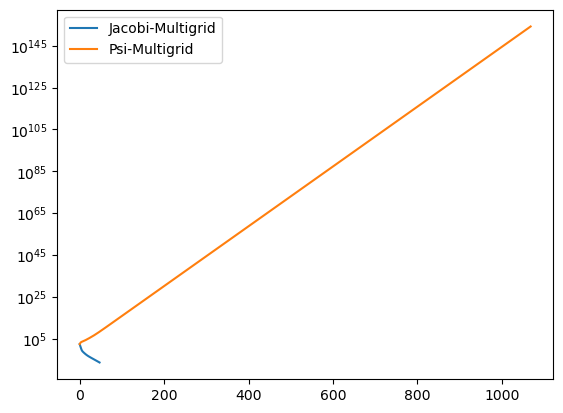

In [ ]:
plt.plot(res_arr_mgjac, label='Jacobi-Multigrid')
plt.plot(res_arr_mgpsi, label='Psi-Multigrid')
plt.yscale('log')
plt.legend()
plt.show()

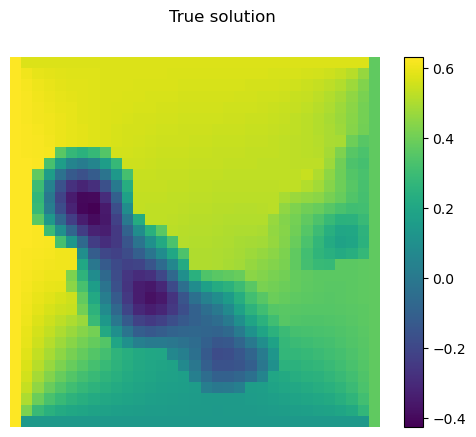

In [ ]:
plot.plot_thermalfield((solution_test).reshape(n+1,n+1), 'True solution')

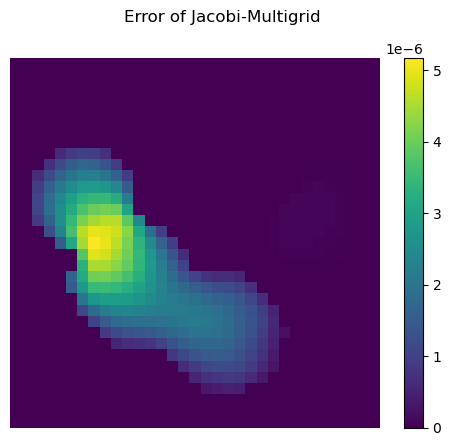

In [ ]:
plot.plot_thermalfield((u_mg_jac-solution_test).reshape(n+1,n+1), 'Error of Jacobi-Multigrid')

In [ ]:
u_mg_jac-solution_test

tensor([[[[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
            0.0000e+00,  0.0000e+00],
          [ 0.0000e+00,  9.9271e-12,  1.9246e-11,  ...,  1.1948e-11,
            5.6216e-12,  0.0000e+00],
          [ 0.0000e+00,  2.0564e-11,  3.9807e-11,  ...,  2.4021e-11,
            1.1441e-11,  0.0000e+00],
          ...,
          [ 0.0000e+00, -1.5091e-11, -2.7261e-11,  ..., -1.8416e-11,
           -1.0660e-11,  0.0000e+00],
          [ 0.0000e+00, -7.1426e-12, -1.2839e-11,  ..., -8.9847e-12,
           -5.2723e-12,  0.0000e+00],
          [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
            0.0000e+00,  0.0000e+00]]]], device='cuda:0', dtype=torch.float64)

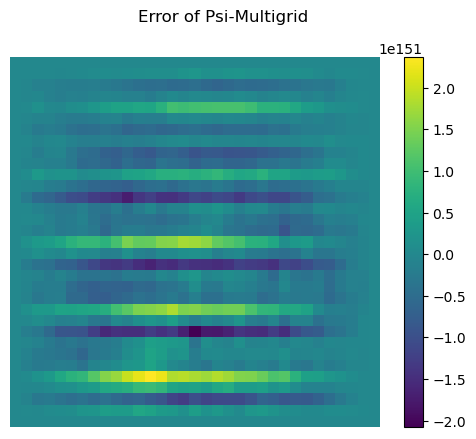

In [ ]:
plot.plot_thermalfield((u_mg_psi.detach()-solution_test).reshape(n+1,n+1), 'Error of Psi-Multigrid')

In [ ]:
u_mg_psi.detach()-solution_test

tensor([[[[  0.0000e+00,   0.0000e+00,   0.0000e+00,  ...,   0.0000e+00,
             0.0000e+00,   0.0000e+00],
          [  0.0000e+00, -1.6367e+148, -8.2570e+148,  ...,  4.0269e+149,
            1.0380e+149,   0.0000e+00],
          [  0.0000e+00, -3.2414e+149, -1.1933e+150,  ..., -2.7011e+149,
            1.9682e+148,   0.0000e+00],
          ...,
          [  0.0000e+00, -9.9603e+149, -3.0219e+150,  ..., -1.1551e+150,
           -1.4387e+148,   0.0000e+00],
          [  0.0000e+00,  1.0728e+149,  3.0631e+148,  ...,  6.5661e+149,
            3.0104e+149,   0.0000e+00],
          [  0.0000e+00,   0.0000e+00,   0.0000e+00,  ...,   0.0000e+00,
             0.0000e+00,   0.0000e+00]]]], device='cuda:0',
       dtype=torch.float64)